# Estimação do Modelo Final
### Autor: Alexandre Saback

# Contextualização do Problema
Agora que a base de dados já foi devidamente explorada, assim como os modelos iniciais, chegou o momento de encontrar um modelo mais robusto que seja capaz de explicar de forma mais precisa as relações presentes nos dados.

# Instalação de Pacotes Adicionais

In [1]:
!pip install statstests
!pip install pyarrow

# Começando
O primeiro passo, mais uma vez, se concentra na importação dos pacotes necessários. A única adição aqui se concentra no _import_ do pacote _xgboost_, o qual possui modelos de _gradient boosting_ que serão utilizados nessa análise.

In [57]:
import pandas as pd
from statstests.tests import shapiro_francia
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Carregando os Dados

## Carregando o Objeto StandardScaler

In [3]:
with open('scaler.pickle', 'rb') as handle:
  scaler = pickle.load(handle)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Carregando o Dataset Pré-processado

In [4]:
dataset = pd.read_parquet("preprocessed_dataset.parquet", engine="pyarrow")

## Selecionando Variáveis Quantitativas e Qualitativas

In [5]:
quanti_features = ['QT_VENDA_BRUTO',
 'QT_DEVOLUCAO',
 'VL_RECEITA_BRUTA',
 'VL_RECEITA_LIQUIDA',
 'PCT_DESCONTO',
 'VL_PRECO']

# Definindo os Parâmetros Iniciais do Modelo

Como teste inicial, os parâmetros abaixo foram definidos de forma arbitrária apenas para produzir um resultado rápido e comparável.

In [6]:
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'alpha': 10,
    'n_estimators': 100
}

In [7]:
# Definição da Variável TARGET
TARGET = "QT_VENDA_BRUTO"

In [8]:
features = [feature for feature in list(dataset.columns) if feature != TARGET]
features = [feature for feature in features if not feature.startswith("COD_MATERIAL")]

# Avaliando o Modelo Utilizando Todos os Dados

Como etapa inicial, decidi não separar os dados em Treino/Teste para realizar comparações fidedignas entre o modelo estimado e os modelos desenvolvidos na exploração anterior.

## Treinando o Modelo

In [9]:
dtrain = xgb.DMatrix(dataset[features], label=dataset[TARGET])

In [10]:
model = xgb.train(params, dtrain, num_boost_round=100)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:28:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
fitted_values = model.predict(dtrain)

## Valores Reais x Valores Estimados

In [12]:
clean_df = dataset.copy()
clean_df[quanti_features] = scaler.inverse_transform(dataset[quanti_features])
clean_df["fitted_values"] = fitted_values * clean_df[TARGET].std() + clean_df[TARGET].mean()

In [13]:
comparison_df = pd.DataFrame(data=[clean_df[TARGET].values, clean_df["fitted_values"]]).T
comparison_df.columns = ["true_values", "fitted_values"]

## Métricas de Erro

In [14]:
print(f"MSE: {mse(comparison_df['true_values'].values, comparison_df['fitted_values'])}")
print(f"MAE: {mae(comparison_df['true_values'].values, comparison_df['fitted_values'])}")

MSE: 46235312.04605888
MAE: 633.6535108196093


Sem muito esforço, o modelo acima apresentou resultados melhores que os dois modelos estimados previamente, atingindo um MAE de 633 em comparação com 5069 do modelo linear e 4.05*10^22 do modelo não linear, se tornando a melhor opção até o momento.

## Feature Importance

Agora, vamos dar uma olhada na contribuição de algumas variáveis para a explicação da variável TARGET.

In [15]:
feature_importances = model.get_score(importance_type='weight')
total = sum(feature_importances.values())
normalized_importances = {k: v / total for k, v in feature_importances.items()}

features_df = pd.DataFrame({
    'Feature': normalized_importances.keys(),
    'Importance': normalized_importances.values()
})

features_df = features_df.sort_values(by='Importance', ascending=False)
top_20_features = features_df.iloc[:20]

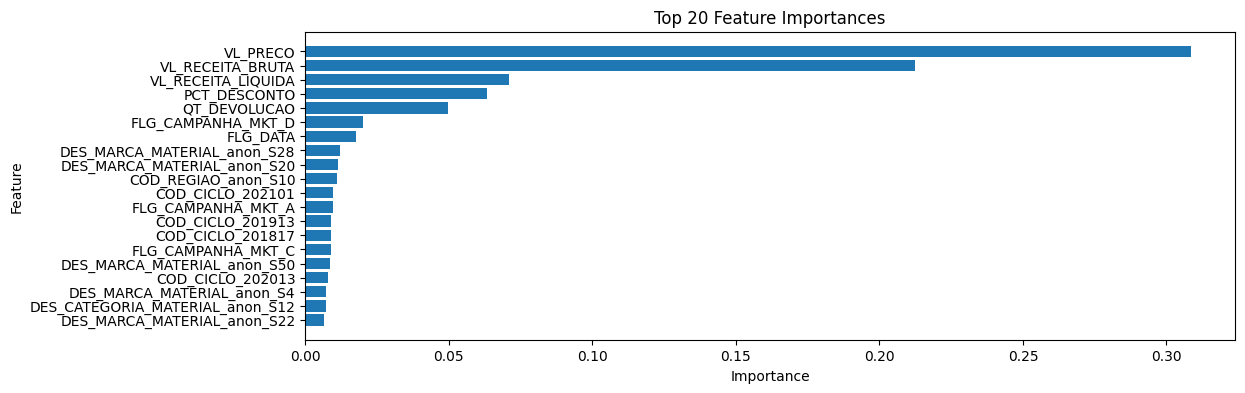

In [16]:
plt.figure(figsize=(12, 4))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()

De acordo com o _plot_ acima, as variáveis `VL_PRECO` e `VL_RECEITA_BRUTA` contribuem fortemente para a explicação do comportamento da variável TARGET, representando cada uma mais de 20% dos pesos atribuídos a cada variável.

É interessante lembrar que a variável `VL_RECEITA_BRUTA` apresentou uma forte correlação positiva com a variável TARGET (`QT_VENDA_BRUTA`) durante a análise exploratória dos dados. Dessa forma, era esperado que tal variável contribuísse fortemente para a explicação da variável dependente.

# Dividindo os Dados em Treino/Teste

Agora, a ideia é dividir os dados em Treino/Teste para que seja possível realizar uma avaliação mais verdadeira do desempenho do modelo em dados não observados durante o treinamento (teste).

In [17]:
train_data = dataset[features]
target_variable = dataset[TARGET]

In [18]:
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(train_data, target_variable, test_size=0.3, random_state=42)

# Ajuste de Hiperparâmetros

Antes de realizar o treino do modelo, optei por realizar um GridSearch de forma rápida e concentrada para encontrar parâmetros que consigam explicar de forma mais precisa os comportamentos observados nos dados.

In [19]:
# Definindo o espaço de busca dos parâmetros
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'alpha': [1, 10, 100]
}

In [20]:
# Definindo o modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [21]:
# Executando GridSearch
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [1, 10, 100],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=3)

De acordo com o método de GridSearch, o modelo com os melhores resultados, dentro dos critérios analisados, possui os parâmetros definidos abaixo.

In [22]:
print(f"Melhores Parâmetros: {grid_search.best_params_}")

Melhores Parâmetros: {'alpha': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


In [23]:
# Reajustando o modelo com os melhores parâmetros
best_model = grid_search.best_estimator_

In [24]:
# Realizando predições
best_predictions = best_model.predict(X_test)

## Valores Reais x Valores Estimados - Base de Validação/Teste

Por fim, chegou o momento de avaliar o modelo no conjunto de teste. Os resultados obtidos aqui não são diretamente comparáveis com os resultados obtidos no modelo anterior, visto que, utilizei somente 70% da base de dados total para realizar o treinamento do modelo e estou avaliando sua performance em apenas 30% dos dados.

In [26]:
clean_df = dataset.copy()
clean_df[quanti_features] = scaler.inverse_transform(dataset[quanti_features])

comparison_df = pd.DataFrame()
comparison_df["true_values"] = y_test.values * clean_df[TARGET].std() + clean_df[TARGET].mean()
comparison_df["fitted_values"] = best_predictions * clean_df[TARGET].std() + clean_df[TARGET].mean()

## Métricas de Erro

In [27]:
print(f'MSE: {mse(comparison_df["true_values"], comparison_df["fitted_values"])}')
print(f'MAE: {mae(comparison_df["true_values"], comparison_df["fitted_values"])}')

MSE: 112326289.8439899
MAE: 774.2348513437599


Embora não seja possível comparar de forma direta os dois modelos estimados nessa análise, é perceptível que o desempenho do modelo "tunado", quando comparado com o modelo inicial, apresenta piores resultados em termos de métricas de erro.

No entanto, tal modelo pode ser mais confiável para realizar extrapolações, ou seja, dados que se distanciam, respeitando um certo limite, dos valores analisados na base de dados original.

## Feature Importance

In [28]:
feature_importances = best_model.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)

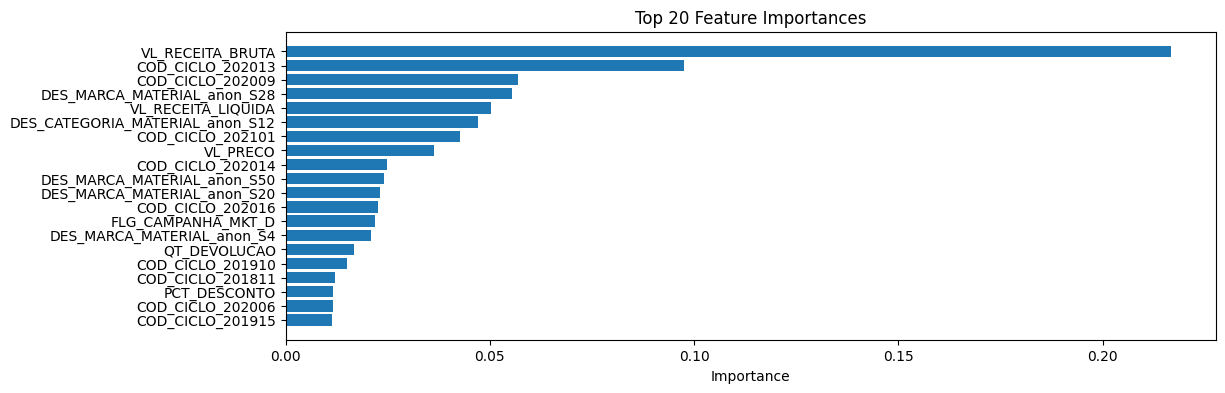

In [30]:
plt.figure(figsize=(12, 4))
plt.barh(features_df['Feature'].iloc[:20], features_df['Importance'].iloc[:20])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.show()

Diferente do modelo anterior, agora a variável `VL_RECEITA_BRUTA` tomou o primeiro lugar de nível de importância. Além disso, é possível observar que diversas variáveis relacionadas com períodos definidos pelo Marketing, como por exemplo, `COD_CICLO_202013` também apresentam um valor considerável de importância na explicação do comportamento da variável TARGET.

Lembrando que, essa análise foi realizada utilizando apenas 70% dos dados disponíveis.

## Avaliando o Modelo Utilizando Todos os Dados
Por fim, apenas para fins comparativos com o modelo inicial, treinarei o modelo com os parâmetros "tunados" utilizando toda a base de dados disponível.

In [40]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    alpha=1,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200)

In [41]:
xgb_fitted = xgb_model.fit(dataset[features], dataset[TARGET])

In [42]:
fitted_values_final = xgb_fitted.predict(dataset[features])

In [43]:
clean_df = dataset.copy()
clean_df[quanti_features] = scaler.inverse_transform(dataset[quanti_features])
clean_df["fitted_values"] = fitted_values_final * clean_df[TARGET].std() + clean_df[TARGET].mean()

In [44]:
comparison_df = pd.DataFrame(data=[clean_df[TARGET].values, clean_df["fitted_values"]]).T
comparison_df.columns = ["true_values", "fitted_values"]

## Métricas de Erro

In [45]:
print(f'MSE: {mse(comparison_df["true_values"], comparison_df["fitted_values"])}')
print(f'MAE: {mae(comparison_df["true_values"], comparison_df["fitted_values"])}')

MSE: 24050192.16876017
MAE: 530.4701784396418


Agora, é possível compararmos de forma direta as métricas de erro entre os dois modelos estimados nessa análise. Tendo isso em vista, o modelo estimado utilizando GridSearch para "tunar" os parâmetros apresentou o melhor o resultado e, portanto, é o mais adequado para realizar predições no conjunto de dados em questão.

## Feature Importances

In [46]:
feature_importances = xgb_fitted.feature_importances_

features_df = pd.DataFrame({
    'Feature': dataset[features].columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)

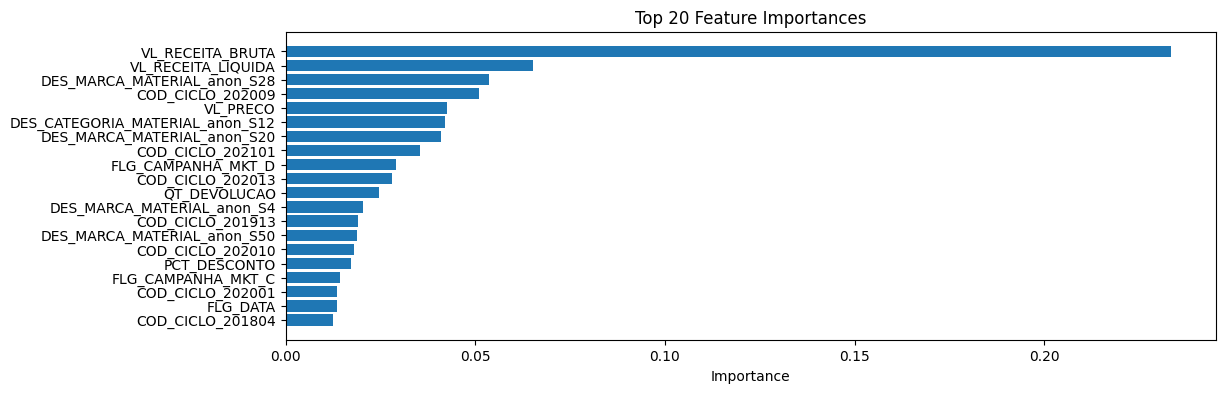

In [47]:
plt.figure(figsize=(12, 4))
plt.barh(features_df['Feature'].iloc[:20], features_df['Importance'].iloc[:20])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.show()

Devido a utilização de mais dados durante o treinamento, a ordem de importância de algumas variáveis foi alterada. No entanto, as duas variáveis mais influentes são justamente aquelas que possuem maior correlação com a variável TARGET, `VL_RECEITA_BRUTA` e `VL_RECEITA_LIQUIDA`.

Além disso, produtos que possuem a marca de material `anon_S28` também apresentam certa importância na explicação da variável dependente (`QT_VENDAS_BRUTO`).

# Analisando os Erros do Modelo

In [49]:
error_evaluation_df = comparison_df.copy()
error_evaluation_df["absolute_error"] = abs(error_evaluation_df["true_values"] - error_evaluation_df["fitted_values"])
error_evaluation_df["squared_error"] = (error_evaluation_df["true_values"] - error_evaluation_df["fitted_values"])**2

In [55]:
# Top 20 Maiores Erros Absolutos
pd.set_option('display.float_format', lambda x: '%.5f' % x)
error_evaluation_df.sort_values("absolute_error", ascending=False).head(20)

,true_values,fitted_values,absolute_error,squared_error
104024,1101456.00000,698484.62500,402971.37500,162385929069.39062
133525,803700.00000,448911.96875,354788.03125,125874547118.25098
137451,1059516.00000,725506.25000,334009.75000,111562513095.06250
63080,1744584.00000,1413441.87500,331142.12500,109655106949.51562
128030,827928.00000,530985.93750,296942.06250,88174588481.75391
147818,1250064.00000,953841.56250,296222.43750,87747732478.44141
58825,789972.00000,516133.71875,273838.28125,74987404277.95410
99542,531336.00000,783489.06250,252153.06250,63581166928.12891
156667,1591062.00000,1339472.62500,251589.37500,63297213612.89062
105491,841338.00000,604406.93750,236931.06250,56136328377.37891


Devido à escala dos dados, o valor médio das métricas de erro é altamente influenciado por valores muito elevados. Sendo assim, não é possível afirmar que o modelo não entrega resultados satisfatórios por apresentar um erro elevado, ainda mais quando o valor do MSE é analisado.

Tendo isso em vista, acredito que seja mais interessante analisar o erro percentual absoluto médio (`MAPE`) em conjunto com o `MAE`, visando obter uma análise métrica mais precisa.

## Interpretando o Erro Percentual Absoluto Médio (MAPE)

In [58]:
print(f'MAPE: {mape(comparison_df["true_values"], comparison_df["fitted_values"])}')

MAPE: 0.06853759603225396


O resultado acima indica um erro percentual relativamente baixo (6.85%), sugerindo que o modelo está performando bem na tarefa de predição de vendas. Um MAPE abaixo de 10% é geralmente considerado bom para muitos cenários de negócios, especialmente no _case_ em questão, onde há muitas variáveis influenciando os resultados.

# Conclusão
Tendo em vista tudo o que foi realizado e discutido nessa e análises prévias, o modelo mais adequado para a realização de previsão de vendas é o modelo XGBoost utilizando os parâmetros definidos através do GridSearch.

No entanto, ainda existe espaço para melhorias, visando reduzir os valores das métricas de erro analisadas. Para isso, seria necessário realizar uma análise mais detalhada, investigando quais variáveis influenciaram de forma negativa a estimativa do modelo nos piores casos.

Além disso, também pode ser interessante utilizar uma arquitetura de redes neurais, o que aumentaria consideravelmente o nível de complexidade do modelo estimado, mas possivelmente entregaria melhores resultados.

De qualquer forma, quando analisada a métrica de erro MAPE, acredito que o modelo estimado entrega bons resultados para o problema de regressão proposto.

Por fim, abaixo ilustro uma tabela comparando os modelos desenvolvidos até então.

In [64]:
comparison_table = pd.DataFrame(columns=["modelo", "MSE", "MAE"])
comparison_table["modelo"] = ["OLS Linear", "OLS Não-Linear", "XGBoost Sem-Tuning", "XGBoost Tunado"]
comparison_table["MAE"] = [5069, "4.05e+22,2", 633.65, 530.47]
comparison_table["MSE"] = [159507782, "2.84e+50", 46235312, 24050192]

In [67]:
comparison_table

,modelo,MSE,MAE
0,OLS Linear,159507782,5069
1,OLS Não-Linear,2.84e+50,"4.05e+22,2"
2,XGBoost Sem-Tuning,46235312,633.65000
3,XGBoost Tunado,24050192,530.47000


## Modelo com Melhor Performance

In [76]:
best_model = pd.DataFrame(
    columns=["modelo", "MSE", "MAE", "MAPE (%)"],
    data=[["XGBoost Tunado", 24050192, 530.47000, 6.85]])

In [77]:
best_model

,modelo,MSE,MAE,MAPE (%)
0,XGBoost Tunado,24050192,530.47000,6.85000
